# pytorch 基础

本课内容包括
1. 基本的pytorch入门
2. pytorch中向量、导数、偏导操作，参考之前线性代数以及微积分
3. 基于pytorch构建一个线性回归网络
4. 基于pytorch实现class1 对图片的分类以及优化

---

参考资料

1. [ws university pytorch introudction](https://courses.cs.washington.edu/courses/cse446/19au/section9.html)
2. [li hong yi](https://www.youtube.com/watch?v=kQeezFrNoOg)
3. [pytorch homepage](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## 1.安装pytorch

与tensorflow相同，pytorch分为cpu版本与gpu版本，官网有相对于安装代码
[安装页面](https://pytorch.org/)



参看本地计算机是否支持GPU以及GPU型号

In [2]:
import torch
def pytrochGPU(memoryview=False):
    support=torch.cuda.is_available()
    if support==True:
        print("GPU is available")
        print("GPU的数量",torch.cuda.device_count())
        print("GPU的名字",torch.cuda.get_device_name(0))
        print("当前GPU索引",torch.cuda.current_device())
    else:
        print("only support cpu")
if __name__ == '__main__':
    print(pytrochGPU())


only support cpu
None


由于可能本地计算机没有gpu，为了避免出错，首先判断是GPU还是CPU，并将数据在对应设备上进行运算

In [3]:
import numpy as np
device="cuda" if torch.cuda.is_available() else "cpu"
x=torch.randn(2,3)
x=x.to(device)
print(x.device)


cpu



pytorch 中torch的作用类似numpy，包括创建数组，进行线性代数运算等，但torch还可以直接进行求导运算

numpy 与 torch之间也可以相互转化

例如numpy中创建数组与torch中创建tensor张量对比

```python 
np.array([12,3])
torch.tensor([12,3])
```

1. array与tensor相互转换


In [5]:
import numpy as np 
if __name__ == '__main__':
    x_tensor=torch.tensor([2,3,2])
    print(type(x_tensor))
    print(x_tensor)
    y_array=x_tensor.numpy()#转换tensor到array
    print(type(y_array))
    print(y_array)

    x_arrray=np.array([[2,2,3],[2,2,2]])
    print(type(x_arrray))
    print(x_arrray.shape)
    y_tensor=torch.from_numpy(x_arrray)
    print(type(y_tensor))
    print(y_tensor.shape)

<class 'torch.Tensor'>
tensor([2, 3, 2])
<class 'numpy.ndarray'>
[2 3 2]
<class 'numpy.ndarray'>
(2, 3)
<class 'torch.Tensor'>
torch.Size([2, 3])


2. tensor 中的线性代数计算
tensor中的计算与numpy中基本一致，包括加减，内积,求norm等。

例如以下代码模拟了一个神经网络affine层中的输入值与权参相乘与偏参相加的计算

In [18]:
# 注意，torch在求norm时，要求数据必须为float数据，故在开始就必须制定向量的数据类型
x=torch.tensor([2,3,3],dtype=float)
w=torch.tensor([[2,2],[1,2],[3,2]],dtype=float)
b=torch.tensor([1,2],dtype=float)
z=x@w+b
print(z)
print(torch.norm(z))

tensor([17., 18.], dtype=torch.float64)
tensor(24.7588, dtype=torch.float64)


tensor中正态分布、随机值等的生成与numpy也一致

```python
torch.rand(维度1数，维度2数，维度3数)
```


In [ ]:
x=torch.rand(2,2,2,2)
print(x)
x_a=np.random.rand(2,2,2,2,2)
print(x_a)

tensor 形状改变
* Tensor.view-改变形状
* Tensor.flatten-降维为1维

We can use the Tensor.view() function to reshape tensors similarly to numpy.reshape()

It can also automatically calculate the correct dimension if a -1 is passed in. This is useful if we are working with batches, but the batch size is unknown.
---
 

In [28]:
batch=1000
img_x=28
img_y=28
#生成一个（1000，28，29）形状的张量，模拟1000张28*28图像
x=torch.rand(batch,img_x,img_y)
print(x.shape)
#将x变更为(1000,784)形状的张量
x2=x.view(batch,img_x*img_y)
print(x2.shape)
#当不确定某维度的大小（batch大小），可以设为-1，torch将自动赋值
x3=x.view(batch,-1)
print(x3.shape)
x3=x.view(-1,784)
print(x3.shape)
#将张量降维为1维
x_fallten=torch.flatten(x)
print(x_fallten.shape)


torch.Size([1000, 28, 28])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([784000])


## Computation graphs 计算图

参考
* [computation graph](https://colah.github.io/posts/2015-08-Backprop/)


What's special about PyTorch's tensor object is that it implicitly creates a computation graph in the background. A computation graph is a a way of writing a mathematical expression as a graph. There is an algorithm to compute the gradients of all the variables of a computation graph in time on the same order it is to compute the function itself.

---

pytorch可以自动实现计算图，Backpropagation反向传播

<img src="figs\tree-def.png" height="50%" width="50%">

例如上图对应计算 $e=(a+b) \times (1+b)$，求$a=1,b=2$时的反向传播

为此，在对tensor复制时候，必须设置**requires_grad=True**从而pytroch将会保留计算图
>we set requires_grad=True to let PyTorch know to keep the graph


In [31]:
a=torch.tensor(1.0,requires_grad=True)
b=torch.tensor(2.0,requires_grad=True)
c=a+b
d=1+b
e=c*d
print(c)
print(d)
print(e)


tensor(3., grad_fn=<AddBackward0>)
tensor(3., grad_fn=<AddBackward0>)
tensor(9., grad_fn=<MulBackward0>)


## PyTorch as an auto grad framework
Now that we have seen that PyTorch keeps the graph around for us, let's use it to compute some gradients for us.

Consider the function  $f(x)=(x−2)^2$
 .

Q: Compute  $\frac{df(x)}{dx}$
  and then compute  $f′(1)$
 .

We make a backward() call on the leaf variable (y) in the computation, computing all the gradients of y at once.

---
1. pytorch 中，张量具有require_grad属性，该属性为True则将跟踪对此张量的所有计算。
2. 完成正向传播计算后，可以对计算结果调用backward（）方法，将自动计算所有梯度，并保存至grad属性中
3. 张量的grad_fn属性将指向运算生成该张量的方法。
通过pytorch中backward可以求得导函数结果


In [38]:
def f(x):
    return (x-2)**2
x=torch.tensor(1.0,requires_grad=True)
y=f(x)
print("正向传播forward:",y)
y.backward()
print("方向传播结果",x.grad)
print(y.grad_fn)


正向传播forward: tensor(1., grad_fn=<PowBackward0>)
方向传播结果 tensor(-2.)


可以设置一个嵌套函数，并求得不同层变量的导数
设
$$y=x^2 \rightarrow z=y+w \rightarrow e=z\times 3+5$$
其中$x=2,w=3$求位于链式求导叶子节点的$\frac{de}{dx},\frac{de}{dw}$

In [47]:
def y(x):
    return x**2
def z(y,w):
    return y+w
def e(z):
    return z*3

if __name__ == '__main__':
    x=torch.tensor(2.0,requires_grad=True)
    w=torch.tensor(3.0,requires_grad=True)
    ##forwad
    y=y(x)
    z=z(y,w)
    e=e(z)
    print("forward result:",e)
    #backward 
    e.backward()
    print("e函数求梯度方法：",e.grad_fn)
    print("y函数求梯度方法：",y.grad_fn)
    print("x的梯度",x.grad)
    print("w的梯度",w.grad)
    

forward result: tensor(21., grad_fn=<MulBackward0>)
e函数求梯度方法： <MulBackward0 object at 0x000002008750C340>
y函数求梯度方法： <PowBackward0 object at 0x000002008750C340>
x的梯度 tensor(12.)
w的梯度 tensor(3.)


It can also find gradients of functions.

Let  $w=[w_1,w_2]^T$
 
Consider  $(w)=2w_1w_2+w_2\cos(w_1)$
 
Q: Compute  $∇wg(w)$
  and verify $ ∇wg([π,1])=[2,π−1]^T$

---

进一步求得偏导数，并构成梯度向量

 

In [51]:
def g(w):
    return 2*w[0]*w[1]+w[1]*torch.cos(w[0])
if __name__ == '__main__':
    w=torch.tensor([torch.pi,1],dtype=float,requires_grad=True)
    print("forwad")
    g=g(w)
    print(g)
    print("backward")
    g.backward()
    print(w.grad)

forwad
tensor(5.2832, dtype=torch.float64, grad_fn=<AddBackward0>)
backward
tensor([2.0000, 5.2832], dtype=torch.float64)


基于以上torch对backward，梯度计算方式，可以结合实现梯度下降法；

---
Using the gradients
Now that we have gradients, we can use our favorite optimization algorithm: gradient descent!

Let  $f$
  the same function we defined above.

Q: What is the value of $ x$
  that minimizes $ f$?

  ---

  注意在此

In [81]:
def f(x):
    return (x-2)**2

if __name__=='__main__':
    iter=100
    learning_rate=0.8
    x=torch.tensor([100.0],requires_grad=True)
    
    for i in range(iter):
        y=f(x)
        y.backward()
        #计算时，必须使用x.data
        x.data=x.data-(x.grad)*learning_rate
        print(x.data)
        
        x.grad.zero_() 


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

基于Pytorch建立线性方程

1. 构建基本的线性方程
2. 描述方程各个部分

---
Linear Module 
 
The bread and butter of modules is the Linear module which does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object.

Unlike how we initialized our  w manually, the Linear module automatically initializes the weights randomly. For minimizing non convex loss functions (e.g. training neural networks), initialization is important and can affect results. If training isn't working as well as expected, one thing to try is manually initializing the weights to something different from the default. PyTorch implements some common initializations in torch.nn.init.

---

pytorch 在linear层将会自动初始化权参、偏参的初始值，通过torch.nn.init 实现。

torch.Size([20, 1])
通过一次forwad后得到y predict
模型中参数： <generator object Module.parameters at 0x000001D4101AD190>
初始权参值: Parameter containing:
tensor([[0.0240]], requires_grad=True)
初始偏参值: Parameter containing:
tensor([-0.9969], requires_grad=True)
第 0 次epoch
第 1 次梯度下降后
模型中权参梯度： tensor([[-374.4066]])
模型中偏参梯度 tensor([-109.2601])
第 2 次梯度下降后
模型中权参梯度： tensor([[-366.3632]])
模型中偏参梯度 tensor([-106.9543])
第 3 次梯度下降后
模型中权参梯度： tensor([[-358.4923]])
模型中偏参梯度 tensor([-104.6979])
第 4 次梯度下降后
模型中权参梯度： tensor([[-350.7903]])
模型中偏参梯度 tensor([-102.4899])
第 5 次梯度下降后
模型中权参梯度： tensor([[-343.2535]])
模型中偏参梯度 tensor([-100.3293])
第 6 次梯度下降后
模型中权参梯度： tensor([[-335.8785]])
模型中偏参梯度 tensor([-98.2150])
第 7 次梯度下降后
模型中权参梯度： tensor([[-328.6617]])
模型中偏参梯度 tensor([-96.1460])
第 8 次梯度下降后
模型中权参梯度： tensor([[-321.5996]])
模型中偏参梯度 tensor([-94.1215])
第 9 次梯度下降后
模型中权参梯度： tensor([[-314.6891]])
模型中偏参梯度 tensor([-92.1403])
第 10 次梯度下降后
模型中权参梯度： tensor([[-307.9269]])
模型中偏参梯度 tensor([-90.2016])
第 11 次梯度下降后
模型中权参梯度： tensor([[-301.3098]])
模型中偏参梯

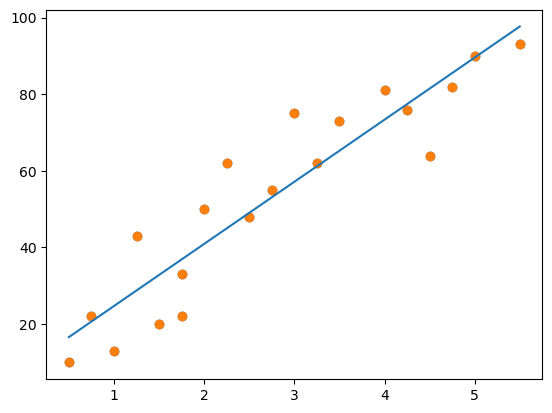

In [43]:
import torch as t 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
class LinerModel(nn.Module):
    def __init__(self):
        super(LinerModel, self).__init__()
        self.linear=nn.Linear(in_features=1,out_features=1)
        self.weight=self.linear.weight
        self.bias=self.linear.bias
    
    def forward(self,x):
        return self.linear(x)
    
    def getParamters(self):
        return self.weight,self.bias
if  __name__ == '__main__':
    
 

    #plt.scatter(x,y)
    x_t=t.tensor([[0.50,0.75,1.00,1.25,1.50,1.75,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,4.00,4.25,4.50,4.75,5.00,5.50]]).T
    y_t=t.tensor([[10,  22,  13,  43,  20,  22,  33,  50,  62, 48,  55,  75,  62,  73,  81,  76,  64,  82,  90,  93]]).T
    x_n=x_t.numpy().T
    y_n=y_t.numpy().T
    plt.scatter(x_n,y_n)
    print(x_t.shape)
    linear_module=LinerModel()
    y_pred=linear_module.forward(x_t)
    print("通过一次forwad后得到y predict")
    weight,bias=linear_module.getParamters()
    print("模型中参数：",linear_module.parameters())
    print("初始权参值:",weight)
    print("初始偏参值:",bias)
    ########################实例化损失函数，优化函数########################################
    loss_fn=nn.MSELoss()#定义均方误差函数作为损失函数
    optimizer=t.optim.SGD(linear_module.parameters(),lr=0.001)#使用SGD优化函数，对inear_module.parameters()中权参、偏参进行梯度下降法优化，学习率为0.001
    
    iter=1000
    i=0
    for epoch in range(iter):#循环10000次epoch
        print("第",epoch,"次epoch")
        for x,y in zip(x_t,y_t):#对训练集中每一个值都投入模型运算并求得对应梯度，并运行一次梯度下降，完成一个epoch
            i+=1
            y_predict=linear_module(x_t)
            y_predict=y_predict.to(t.float32)
            y_t=y_t.to(t.float32)
            loss=loss_fn(y_predict, y_t)
            optimizer.zero_grad()#清空上次的梯度积累
            loss.backward()#损失函数进行backward反向传播
            if iter>900:
                
                print("第",i,"次梯度下降后")
                print("模型中权参梯度：",linear_module.weight.grad)
                print("模型中偏参梯度",linear_module.bias.grad)
            optimizer.step()#根据计算得到的梯度开始梯度下降更新即W=W-∇w*learningrate
    
    ################################输出最终优化的权参和偏参##############################################
    print("优化后得到权参、偏参分别为：",list(linear_module.named_parameters()))
    y_predict=linear_module(x_t).detach().numpy()#通过模型进行预测.detach()实现返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置,不同之处只是requires_grad为false，得到的这个tensor永远不需要计算其梯度，不具有grad。
    plt.scatter(x_n,y_n)
    plt.plot(x_t,y_predict)
    
    

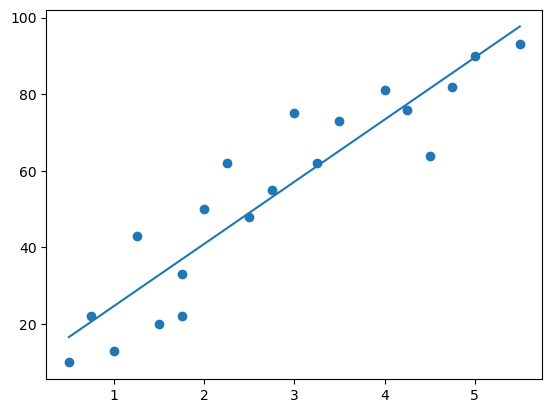

In [110]:
d_in = 3
d_out = 4
linear_module = nn.Linear(1, d_out)

example_tensor = torch.tensor([[1.,2,3]]).T
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([3, 1])
transormed torch.Size([3, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[ 0.7270],
        [ 0.7984],
        [-0.8338],
        [ 0.7386]], requires_grad=True)
b: Parameter containing:
tensor([ 0.5252, -0.5931,  0.0407,  0.5955], requires_grad=True)


模型的改进

以上模型没有加入激活函数，只是一个简单的一层线性全连接网络。

以下改进模型，加入激活层，使用relu激活函数：

---

Activation functions
PyTorch implements a number of activation functions including but not limited to ReLU, Tanh, and Sigmoid. Since they are modules, they need to be instantiated.

---

pytorch中，激活层的使用与之前numpy构建相似，首先实例化一个激活函数，正向传播全连接层input的数据后，得到激活值，传递给下一个全连接层。

In [49]:
relu_fn=nn.ReLU()#实例化Relu函数
x=t.randn(2,dtype=float)
print(x)
print("relu 激活函数很简单，即如果x>0则输出x反之输出0")
y=relu_fn.forward(x)
print(y)



tensor([1.4335, 0.6307], dtype=torch.float64)
relu 季候函数
tensor([1.4335, 0.6307], dtype=torch.float64)


实现将激活函数加入之前线性层之后，注意输出层也必须为一个线性层，而后在外部使用平均误差函数